# Torchtext processing

In [37]:
import matplotlib as plt
%matplotlib inline
import numpy as np 
import pandas as pd 
import torch
import torchtext
from torchtext import data
import spacy
import os

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy
from sklearn.metrics import roc_auc_score

spacy_en = spacy.load('en')

_stopwords = spacy.lang.en.stop_words.STOP_WORDS

os.environ['OMP_NUM_THREADS'] = '4'


SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [38]:
# Add padding to avoid having contributions which cannot be passed to the model
def tokenizer(text):
    token = [t.text for t in spacy_en.tokenizer(text)]
    for i in range(1, 4 ):
        token.append('<PAD>')
    return token

# Tokenizing and remove stopwords with spicy
TEXT = data.Field(lower=True,include_lengths=True,tokenize=tokenizer)
#Uncomment line below to remove stopwods
#TEXT = data.Field(lower=True,include_lengths=True,tokenize=tokenizer, stop_words = _stopwords)
LABEL = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                            unk_token=None, dtype = torch.float)

dataFields = {"comment_text": ("comment_text", TEXT), 
              'toxic': ("toxic", LABEL), 
              'severe_toxic': ("severe_toxic", LABEL),
              'threat': ("threat", LABEL), 
              'obscene': ("obscene", LABEL),
              'insult': ("insult", LABEL), 
              'identity_hate': ("identity_hate", LABEL)}

In [39]:
data_dir = '../data/'
data_name = 'train_preprocessed.json'

In [40]:
dataset= data.TabularDataset(path=data_dir+data_name, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=True)

In [41]:
import random
SEED = 3
train_data, val_data = dataset.split(split_ratio=0.9,random_state = random.seed(SEED))

In [42]:
MAX_VOCAB_SIZE = 20_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [43]:
BATCH_SIZE = 256 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, val_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.comment_text),
    sort_within_batch = True,
    device = device)

In [44]:
# Save vocab
import pickle
pickle.dump(TEXT, open('../stored_models/lstm_TEXT_vocab', 'wb'))

# Pytorch LSTM model

In [78]:
import torch.nn as nn
from torch.functional import F

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dense_dim ,output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, dense_dim)
        
        self.dropout_dense = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(dense_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
        
        #Doc missing below
        dense = self.fc1(hidden)
        
        dense = F.relu(dense)
        
        dense = self.dropout_dense(dense)
        
        return self.fc2(dense)

In [79]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 30 #256
DENSE_DIM = 30
OUTPUT_DIM = 6 #1 
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM,
            DENSE_DIM,
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,055,976 trainable parameters


In [12]:
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1898, -0.1176, -0.3154,  ...,  0.0558, -0.7294, -0.4067],
        [-0.3683, -0.5918,  0.2659,  ..., -0.4553,  0.3215,  0.0155],
        [-0.1904,  0.2684, -0.1786,  ..., -0.2058, -0.2766, -0.5358]])

In [13]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1898, -0.1176, -0.3154,  ...,  0.0558, -0.7294, -0.4067],
        [-0.3683, -0.5918,  0.2659,  ..., -0.4553,  0.3215,  0.0155],
        [-0.1904,  0.2684, -0.1786,  ..., -0.2058, -0.2766, -0.5358]])


In [14]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

## Define training and evaluation functions

In [15]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    yFields = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
    epoch_loss = 0; epoch_acc = 0
    preds_list=[]; labels_list= []; epoch_loss_hist = []
 
    j = len(iterator)//2 
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.comment_text        
        predictions = model(text, text_lengths).squeeze(1)        
        batch_labels=torch.stack([getattr(batch, y) for y in yFields]) #transpose?
        batch_labels = torch.transpose(batch_labels,0,1)        
        loss = criterion(predictions, batch_labels)        
        loss.backward()        
        optimizer.step()
        
        preds_list+=[torch.sigmoid(predictions).detach().numpy()]
        labels_list+=[batch_labels.numpy()]
        
        if i%j ==0:
            epoch_loss_hist.append([loss.item(),
            evaluate(model, valid_iterator, criterion)[0]])
            model.train()
            
        
        epoch_loss += loss.item()
                        
    return (epoch_loss / len(iterator) , epoch_loss_hist, 
           roc_auc_score(np.vstack(labels_list), np.vstack(preds_list)))

In [16]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    yFields = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
    epoch_loss = 0; epoch_acc = 0
    preds_list=[]; labels_list= []; epoch_acc=[]
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.comment_text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            batch_labels = torch.stack([getattr(batch, y) for y in yFields]) #transpose?
            batch_labels = torch.transpose(batch_labels,0,1)
            
            loss = criterion(predictions, batch_labels)

            epoch_loss += loss.item()
            
            preds_list+=[torch.sigmoid(predictions).detach().numpy()]
            labels_list+=[batch_labels.numpy()]
        
            #if i%64==0:
            #    epoch_acc += [roc_auc(np.vstack(preds_list), np.vstack(batch_labels))]
            #    preds_list=[]
            #    labels_list= []
        
    return (epoch_loss / len(iterator),
           roc_auc_score(np.vstack(labels_list), np.vstack(preds_list)) ,
           np.vstack(preds_list), np.vstack(labels_list))

In [17]:
def print_metrics(pred, labels, thre= 0.5):
    toxic_labels = ['toxic','severe_toxic',
               'obscene','threat','insult',
               'identity_hate']
    
    roc_auc_scores= []
    recall_scores=[]
    precision_scores=[]
    accuracy_scores=[]
    f1_scores=[]

     
    for i,j in enumerate(toxic_labels):
        roc_auc_scores.append(roc_auc_score(labels[:,i], pred[:,i]))
        recall_scores.append(recall_score(labels[:,i], pred[:,i]>=thre))
        accuracy_scores.append(accuracy_score(labels[:,i], pred[:,i]>=thre))
        precision_scores.append(precision_score(labels[:,i], pred[:,i]>=thre))
        f1_scores.append(f1_score(labels[:,i], pred[:,i]>=thre))
    return pd.DataFrame(
    {'Label': toxic_labels,
     'accuracy': accuracy_scores,
     'recall': recall_scores,
     'precision': precision_scores,
     'f1': f1_scores,
     'roc_auc': roc_auc_scores})

## Training on dataset

In [18]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
N_EPOCHS = 5

best_valid_loss = float('inf')

loss_hist=[]; acc_hist=[]

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _loss_hist, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, _preds  , _labels  = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    
    loss_hist+= _loss_hist
    acc_hist+= [[valid_acc, train_acc]]
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../stored_models/lstm-model.pt')            
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 7m 58s
	Train Loss: 0.137 | Train Acc: 83.42%
	 Val. Loss: 0.058 |  Val. Acc: 96.87%
Epoch: 02 | Epoch Time: 7m 59s
	Train Loss: 0.063 | Train Acc: 95.42%
	 Val. Loss: 0.053 |  Val. Acc: 97.28%
Epoch: 03 | Epoch Time: 7m 50s
	Train Loss: 0.057 | Train Acc: 96.01%
	 Val. Loss: 0.050 |  Val. Acc: 97.60%
Epoch: 04 | Epoch Time: 7m 46s
	Train Loss: 0.054 | Train Acc: 96.68%
	 Val. Loss: 0.049 |  Val. Acc: 97.70%
Epoch: 05 | Epoch Time: 7m 48s
	Train Loss: 0.052 | Train Acc: 96.94%
	 Val. Loss: 0.050 |  Val. Acc: 97.77%


In [80]:
model.load_state_dict(torch.load('../stored_models/lstm-model.pt'))

<All keys matched successfully>

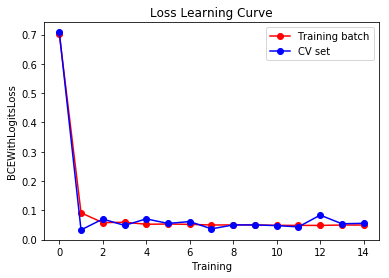

In [81]:
import matplotlib.pyplot as plt
title = 'Loss Learning Curve'
plt.title(title)
plt.plot([i[1] for i in loss_hist], 'o-', color="r",label= "Training batch")
plt.plot([i[0] for i in loss_hist],  'o-', color="b", label="CV set")
plt.legend(loc="best")
plt.xlabel("Training")
plt.ylabel("BCEWithLogitsLoss")
plt.savefig('../plots_tables/'+'lstm_'+title.replace(' ', '_')+'.png')

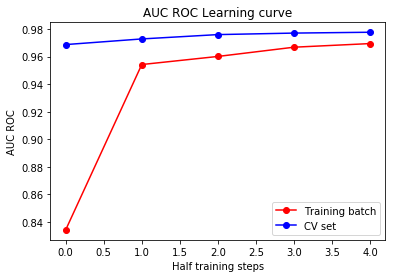

In [82]:
title = 'AUC ROC Learning curve'
plt.title(title)
plt.plot([i[1] for i in acc_hist], 'o-', color="r",label= "Training batch")
plt.plot([i[0] for i in acc_hist],  'o-', color="b", label="CV set")
plt.legend(loc="best")
plt.xlabel("Half training steps")
plt.ylabel("AUC ROC")
plt.savefig('../plots_tables/'+'lstm_'+title.replace(' ', '_')+'.png')

In [22]:
print_metrics(_preds , _labels,0.45)

/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/me

,Label,accuracy,recall,precision,f1,roc_auc
0,toxic,0.965720,0.721344,0.898277,0.800146,0.977577
1,severe_toxic,0.991414,0.000000,0.000000,0.000000,0.989878
2,obscene,0.978693,0.822222,0.772622,0.796651,0.985101
3,threat,0.997431,0.000000,0.000000,0.000000,0.961309
4,insult,0.973178,0.739130,0.720698,0.729798,0.984267
5,identity_hate,0.991978,0.000000,0.000000,0.000000,0.967836


# Testing 

In [45]:
data_test = 'test_preprocessed.json'

In [87]:

dataFields = {"comment_text": ("comment_text", TEXT)}

testDataset= data.TabularDataset(path=data_dir+data_test, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=False)


In [88]:
test_iterator = torchtext.data.Iterator(testDataset, batch_size=64, sort=False,   
                                        sort_within_batch=False, repeat=False,shuffle=False)

In [89]:
myPreds=[]
with torch.no_grad():
    model.eval()
    for batch in test_iterator:

        torch.cuda.empty_cache()
    
        text, text_lengths = batch.comment_text
        predictions = model(text, text_lengths).squeeze(1)        
        myPreds+=[torch.sigmoid(predictions).detach().numpy()]
    
        torch.cuda.empty_cache()
myPreds = np.vstack(myPreds)

In [90]:
len(myPreds), len(testDF)

(153164, 153164)

In [91]:
testDF= pd.read_csv("../data/test.csv")
for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    testDF[col] = myPreds[:, i]

In [92]:
testDF.drop("comment_text", axis=1).to_csv("../results_for_kaggle/lstm_kaggle.csv", index=False)